# Sentence selector

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import os
import glob
import itertools
import operator
import string

# scikit learn imports
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import scale, StandardScaler, Normalizer, label_binarize
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve, accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import PredefinedSplit
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

# visualization
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import umap

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
#nltk.download()
from nltk import ngrams, pos_tag

# Libraries for imbalanced data
# import imblearn
# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SMOTENC, SVMSMOTE
# from imblearn.keras import BalancedBatchGenerator
# from imblearn.pipeline import Pipeline as imbPipeline

/home/anjani/anaconda3/envs/systreviewclassifi/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def plot_confMatrix(y_test, y_predicted_counts):
    
    cm = confusion_matrix(y_test, y_predicted_counts)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['High-Grade','Low-Grade'], normalize=False, title='Confusion matrix')
    plt.show()
    print('the confusion matrix: ', cm)

In [3]:
normalizer = Normalizer()

In [4]:
# Build sentences from the EBM-NLP dataset

# hilfiker
par_text_dir_t2 = '/home/anjani/systematicReviews/data/TA_screening/hilfiker_sr_ta/PICO_annotation_project/validation_files/tokens'
par_lab_dir_t2 = '/home/anjani/systematicReviews/data/TA_screening/hilfiker_sr_ta/PICO_annotation_project/validation_files/labels/intervention/annot'

# EBM-NLP training
par_text_dir = '/home/anjani/systematicReviews/data/TA_screening/EBM_NLP/ebm_nlp_2_00/documents/train/'
par_lab_dir = '/home/anjani/systematicReviews/data/TA_screening/EBM_NLP/ebm_nlp_2_00/annotations/aggregated/starting_spans/interventions/train/'

# EBM-NLP Gold
par_text_dir_t1 = '/home/anjani/systematicReviews/data/TA_screening/EBM_NLP/ebm_nlp_2_00/documents/test/'
par_lab_dir_t1 = '/home/anjani/systematicReviews/data/TA_screening/EBM_NLP/ebm_nlp_2_00/annotations/aggregated/starting_spans/interventions/test/gold/'

print('Number of documents: ', len([name for name in os.listdir(par_text_dir) if os.path.isfile(os.path.join(par_text_dir, name))]) /3)
print('Number of doc labels: ', len([name for name in os.listdir(par_lab_dir) if os.path.isfile(os.path.join(par_lab_dir, name))]))

Number of documents:  4802.0
Number of doc labels:  4782


In [5]:
write_file = '/home/anjani/systematicReviews/data/TA_screening/EBM_NLP/allSentence_annot/hilfiker_sentence_annotation2POS.txt'

from nltk.tokenize.punkt import PunktSentenceTokenizer
import nltk, json

def getData(par_text_dir, par_lab_dir):
    all_text_files = os.listdir(par_text_dir)

    sentences_wwo_intervention = 0
    sentences_with_intervention = 0
    sentences_without_intervention = 0

    sent_w_intannot = []
    sent_w_intannotLab = []
    sent_wo_intannot = []
    sent_wo_intannotLab = []

    for i, eachFile in enumerate(all_text_files):
        if '.tokens' in eachFile or '.txt' in eachFile and '1530836' not in eachFile:

            document = os.path.join(par_text_dir, eachFile)
            if '.tokens' in eachFile:
                label_extension = '.AGGREGATED.ann'
                label = os.path.join(par_lab_dir, str(eachFile).replace('.tokens', label_extension))
            else:
                label_extension = '.txt'
                label = os.path.join(par_lab_dir, str(eachFile).replace('.txt', label_extension))

            added_length = 0
            if os.path.isfile(label):

                write_document = dict()
                token_list = []
                label_list = []
                with open(label, 'r') as labfile, open(document, 'r') as docfile:
                    for eachToken, eachTokLabel in zip(docfile, labfile):
                        string2print = eachToken.rstrip() + ' : ' + eachTokLabel.rstrip()

                        token_list.append(eachToken.rstrip())
                        label_list.append(eachTokLabel.rstrip())                    

                s = nltk.sent_tokenize(' '.join(token_list)) # converts tokens into sentences
                reSent = ' '.join(s) # joins the sentences into a passage
                retokens = reSent.split(' ')
                assert len(token_list) == len(label_list) == len(retokens)

                reformed = []

                write_sentences = dict()
                for j, eachSentence in enumerate(s):
                    words = eachSentence.split(' ')
                    reformed.extend( words )

                    fetchLab = len(words)
                    sent_lab = label_list[added_length : added_length + fetchLab]          

                    added_length = added_length + fetchLab
                    if all(p == '0' for p in sent_lab) is False:
                        #print(words)
                        write_sentences[str(j)] = [words, sent_lab, [eachTuple[1]  for eachTuple in nltk.pos_tag_sents([words])[0]]]
                        sentences_with_intervention = sentences_with_intervention + 1
                        # Remove stopwords and punctuations from the input sentence
                        filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
                        words2string = ' '.join(filtered_words).lower()
                        removePunct = words2string.translate(str.maketrans('', '', string.punctuation))
                        sent_w_intannot.append( removePunct )
                        sent_w_intannotLab.append( 1 )
                    else:
                        #print('No intervention: ' , words)
                        # writes even if no annotations are found in the sentence
                        write_sentences[str(j)] = [words, sent_lab, [eachTuple[1]  for eachTuple in nltk.pos_tag_sents([words])[0]]]
                        sentences_without_intervention = sentences_without_intervention + 1
                        filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
                        words2string = ' '.join(filtered_words).lower()
                        removePunct = words2string.translate(str.maketrans('', '', string.punctuation))
                        sent_wo_intannot.append( removePunct )
                        sent_wo_intannotLab.append( 0 )

                    sentences_wwo_intervention = sentences_wwo_intervention + 1

                assert len(token_list) == len(reformed)
                write_document[eachFile] = write_sentences

                #with open(write_file, 'a+') as writeAnnotfile:
                    #print(write_document)
                    #json_str = json.dumps(write_document)
                    #writeAnnotfile.write(str(json_str))
                    #writeAnnotfile.write('\n')
                #print('--------------------------------------------------------')
    print('Number of sentences with and without intervention annotation: ' , sentences_wwo_intervention)
    print('Number of sentences with intervention annotation: ' , sentences_with_intervention)
    print('Number of sentences without intervention annotation: ' , sentences_without_intervention)
    
    return sent_w_intannot, sent_w_intannotLab, sent_wo_intannot, sent_wo_intannotLab

In [6]:
# Get training data
sent_w_intannot, sent_w_intannotLab, sent_wo_intannot, sent_wo_intannotLab = getData(par_text_dir, par_lab_dir)

Number of sentences with and without intervention annotation:  51577
Number of sentences with intervention annotation:  23241
Number of sentences without intervention annotation:  28336


In [7]:
# Get test data
sent_w_intannot_t1, sent_w_intannotLab_t1, sent_wo_intannot_t1, sent_wo_intannotLab_t1 = getData(par_text_dir_t1, par_lab_dir_t1)

Number of sentences with and without intervention annotation:  2068
Number of sentences with intervention annotation:  1107
Number of sentences without intervention annotation:  961


In [8]:
sent_w_intannot_t2, sent_w_intannotLab_t2, sent_wo_intannot_t2, sent_wo_intannotLab_t2 = getData(par_text_dir_t2, par_lab_dir_t2)

Number of sentences with and without intervention annotation:  2080
Number of sentences with intervention annotation:  856
Number of sentences without intervention annotation:  1224


In [9]:
# Get training dataframe
sentsX = sent_w_intannot + sent_wo_intannot
sentsy = sent_w_intannotLab + sent_wo_intannotLab
print(len(sentsX))
print(len(sentsy))

51577
51577


In [10]:
# Get test dataframe
sentsXtest = sent_w_intannot_t1 + sent_wo_intannot_t1
sentsytest = sent_w_intannotLab_t1 + sent_wo_intannotLab_t1
print(len(sentsXtest))
print(len(sentsytest))

2068
2068


In [11]:
# Get test dataframe
sentsXtest2 = sent_w_intannot_t2 + sent_wo_intannot_t2
sentsytest2 = sent_w_intannotLab_t2 + sent_wo_intannotLab_t2
print(len(sentsXtest2))
print(len(sentsytest2))

2080
2080


In [12]:
# Construct the vocab from all the dataframes and remove all the words that are represented less than 10 times in the entire corpus

vocabulary = dict()

print('Generating vocabulary for the training set')
for eachText in sentsX:
    
    eachText = eachText.split(' ')

    # generate the vocabulary
    for t in eachText:
        if t not in vocabulary:
            vocabulary[t] = 1
        elif t in vocabulary:
            vocabulary[t] = vocabulary[t] + 1

print('Generating vocabulary for the test set 1')
for eachText in sentsXtest:
    
    eachText = eachText.split(' ')

    # generate the vocabulary
    for t in eachText:
        if t not in vocabulary:
            vocabulary[t] = 1
        elif t in vocabulary:
            vocabulary[t] = vocabulary[t] + 1

print('Generating vocabulary for the test set 2')
for eachText in sentsXtest2:
    
    eachText = eachText.split(' ')

    # generate the vocabulary
    for t in eachText:
        if t not in vocabulary:
            vocabulary[t] = 1
        elif t in vocabulary:
            vocabulary[t] = vocabulary[t] + 1
            
print('Size of vocabulary: ', len(vocabulary))

Generating vocabulary for the training set
Generating vocabulary for the test set 1
Generating vocabulary for the test set 2
Size of vocabulary:  42376


In [13]:
# Remove tokens that do not appear more than 10 times in the entire corpus
sentsXtest_reduced = [ ]

print('Reduce tokens in test set 1')
for eachText in sentsXtest:
    
    text_i = eachText.split(' ')
    sample_i = [ ]
    for t in text_i:
        if vocabulary[t] > 10:
            sample_i.append( t )
    sentsXtest_reduced.append( ' '.join(sample_i) )

Reduce tokens in test set 1


In [14]:
sentsXtest2_reduced = [ ]

print('Reduce tokens in test set 2')
for eachText in sentsXtest2:
    
    text_i = eachText.split(' ')
    sample_i = [ ]
    for t in text_i:
        if vocabulary[t] > 10:
            sample_i.append( t )
    sentsXtest2_reduced.append( ' '.join(sample_i) )

Reduce tokens in test set 2


In [15]:
sentsX_reduced = [ ]
print('Reduce tokens in training set')
for eachText in sentsX:
    
    text_i = eachText.split(' ')
    sample_i = [ ]
    for t in text_i:
        if vocabulary[t] > 10:
            sample_i.append( t )
    sentsX_reduced.append( ' '.join(sample_i) )

Reduce tokens in training set


In [16]:
assert len(sentsX) == len(sentsX_reduced) 
assert len(sentsXtest) == len(sentsXtest_reduced) == len(sentsytest)
assert len(sentsXtest2) == len(sentsXtest2_reduced) == len(sentsytest2)

In [17]:
vocabulary_reduced = {key:val for key, val in vocabulary.items() if val > 10}
print(len(vocabulary_reduced))

7648


In [20]:
df_data = pd.DataFrame(
    {'text': sentsX_reduced,
     'category': sentsy
    })

print('Dataframe with training set: ', len(df_data))

df_testdata = pd.DataFrame(
    {'text': sentsXtest_reduced,
     'category': sentsytest
    })

print('Dataframe with training set: ', len(df_testdata))


df_testdata2 = pd.DataFrame(
    {'text': sentsXtest2_reduced,
     'category': sentsytest2
    })

print('Dataframe with training set: ', len(df_testdata2))

Dataframe with training set:  51577
Dataframe with training set:  2068
Dataframe with training set:  2080


### Data exploration

In [21]:
print('Number of reports with the intervention annotation: ', list(df_data['category']).count(1))
print('Number of reports without the intervention annotation: ', list(df_data['category']).count(0))

Number of reports with the intervention annotation:  23241
Number of reports without the intervention annotation:  28336


Text(0.5,1,'Number of sentences with and without intervention annotation.')

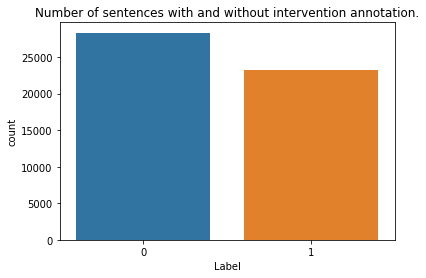

In [22]:
sns.countplot(df_data.category)
plt.xlabel('Label')
plt.title('Number of sentences with and without intervention annotation.')

### Baseline Experiments (tf-idf, no oversampling)

In [23]:
def get_param_grids(s):
    
    if 'logistic_regression' in s:
        
        param_grid = [{'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                      'vect__max_features': (None, 5000, 10000, 50000),
                      'vect__max_df': [0.7, 0.8, 0.9],
                      'vect__min_df': [0.0, 0.1, 0.2, 0.3],
                      'vect__norm': ['l1','l2'],
                      'clf__penalty': ['l1','l2'],
                      'clf__class_weight': ['balanced', None]
              }
             ]
          
        return param_grid
    
    if 'svm' in s:      
  
        param_grid = [{'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                       'vect__max_features': (None, 5000, 10000, 50000),
                       'vect__max_df': [0.7, 0.8, 0.9],
                       'vect__min_df': [0.0, 0.1, 0.2, 0.3],
                       'vect__norm': ['l1','l2']
                      }
                     ]
        
        return param_grid
    
    if 'knn' in s:
        
        param_grid = [{'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                        'vect__max_features': (None, 5000, 10000, 50000),
                        'vect__max_df': [0.7, 0.8, 0.9],
                        'vect__min_df': [0.0, 0.1, 0.2, 0.3],
                        'vect__norm': ['l1','l2'],
                        'clf__n_neighbors': [9, 11, 21, 31],
                        'clf__metric': ['minkowski', 'euclidean']
              }
             ]
        
        return param_grid
    
    if 'trial' in s:
        
        param_grid = [{'clf__penalty': ['l2']
              }
             ]
        
        return param_grid
    
    else:
        raise ValueError('Please correctly specify the name of algorithm to apply...')

In [24]:
def get_classifier_pipeline(s):
    
    # Initialize vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words=None, smooth_idf=True)
    
    if 'logistic_regression' in s:
        
        log_reg_clf = LogisticRegression(intercept_scaling=1, random_state=42)
        log_reg_clf_tfidf = Pipeline([('vect', tfidf_vectorizer), ('scaler', normalizer), ('clf', log_reg_clf)])
        
        return log_reg_clf_tfidf
    
    if 'svm' in s:
        
        svm_clf = CalibratedClassifierCV(base_estimator=LinearSVC(penalty = 'l2', class_weight = 'balanced', fit_intercept=False, random_state=42, verbose=1, dual=False))
        svm_clf_tfidf = Pipeline([('vect', tfidf_vectorizer), ('norm', normalizer), ('clf', svm_clf)])
        
        return svm_clf_tfidf
    
    if 'knn' in s:
        
        knn_clf = KNeighborsClassifier(weights='uniform', algorithm='auto')
        knn_clf_tfidf = Pipeline([('vect', tfidf_vectorizer), ('norm', normalizer), ('clf', knn_clf)])
        
        return knn_clf_tfidf
    
    if 'trial' in s:
        
        svm_clf = CalibratedClassifierCV(base_estimator=LinearSVC(penalty='l2', fit_intercept=False, class_weight='balanced', random_state=42, verbose=1, dual=False))
        print(svm_clf.get_params().keys())
        svm_clf_tfidf = Pipeline([('vect', tfidf_vectorizer), ('norm', normalizer), ('clf', svm_clf)])
        
        return svm_clf_tfidf
        
    else:
        raise ValueError('Please correctly specify the name of algorithm to apply...')

In [25]:
def evaluate(gridSearch, X_test, y_test):
    
    test_roc_auc = []
    
    precision_include = []
    recall_include = []
    f1_include = []

    precision_exclude = []
    recall_exclude = []
    f1_exclude = []
    
    # Using best model, predict on the test set
    print('-' * 30)
    y_pred = gridSearch.best_estimator_.predict(X_test)

    y_test = y_test.to_numpy()
    y_test = y_test.astype('int')

    ROCAUC_score = roc_auc_score(y_test, y_pred)
    print('The ROC-AUC score for the test set is: ', ROCAUC_score)
    test_roc_auc.append(ROCAUC_score)

    classReport =  classification_report(y_test, y_pred)
    print(classReport)

    ## Plot confusion matrix
    plot_confMatrix(y_test, y_pred)

    prec_scr = precision_score(y_test, y_pred, average=None)
    rec_scr = recall_score(y_test, y_pred, average=None)
    f_scr = f1_score(y_test, y_pred, average=None)

    precision_include.append(prec_scr[1])
    recall_include.append(rec_scr[1])
    f1_include.append(f_scr[1])

    precision_exclude.append(prec_scr[0])
    recall_exclude.append(rec_scr[0])
    f1_exclude.append(f_scr[0])
        
    ## Print mean scores here
    meanTrainPRU = sum(train_roc_auc)/len(train_roc_auc)
    meanTestPRU = sum(test_roc_auc)/len(test_roc_auc)

    print('Mean training ROC-AUC score is: ', meanTrainPRU)
    print('Mean test ROC-AUC score is: ', meanTestPRU)

    meanP = sum(precision_include)/len(precision_include)
    meanR = sum(recall_include)/len(recall_include)
    meanF1 = sum(f1_include)/len(f1_include)

    print('Mean precision for positive sentences is: ', meanP)
    print('Mean recall for positive sentences is: ', meanR)
    print('Mean F1 for positive sentences is: ', meanF1)

    meanP_0 = sum(precision_exclude)/len(precision_exclude)
    meanR_0 = sum(recall_exclude)/len(recall_exclude)
    meanF1_0 = sum(f1_exclude)/len(f1_exclude)

    print('Mean precision for negative sentences is: ', meanP_0)
    print('Mean recall for negative sentences is: ', meanR_0)
    print('Mean F1 for negative sentences is: ', meanF1_0)    

In [29]:
def execute_baselines(s, df_data, df_testdata, df_testdata2):
    
    # Shuffle the dataframes
    df_data = df_data.sample(frac=1).reset_index(drop=True)
    df_testdata = df_testdata.sample(frac=1).reset_index(drop=True)
    df_testdata2 = df_testdata2.sample(frac=1).reset_index(drop=True)

    train_roc_auc = []
   
    #for i in range(0, 3):
        
    # get training and test datasets
    X_train, y_train = df_data['text'], df_data['category']
    X_test1, y_test1 = df_testdata['text'], df_testdata['category']
    X_test2, y_test2 = df_testdata2['text'], df_testdata2['category']

    # get training and evaluation datasets
    #X_train, X_eval, y_train, y_eval = train_test_split(X_train_i, y_train_i, test_size=0.20, shuffle=True, random_state=42)

    print('-' * 30)
    print('Training set has ', list(y_train).count(1), ' positive instances and ', list(y_train).count(0), ' negative instances.')
    print('Test set 1 has ', list(y_test1).count(1), ' positive instances and ', list(y_test1).count(0), ' negative instances.')
    print('Test set 2 has ', list(y_test2).count(1), ' positive instances and ', list(y_test2).count(0), ' negative instances.')
    print('-' * 30)
    print('\n')


    # Get the test fold from above split
    #testFold = getTestFold(X_train, y_train, X_eval, y_eval)
    #ps = PredefinedSplit(testFold)

    #series_list_corpus = [X_train, X_eval]
    #series_list_label = [y_train, y_eval]

    #X_train_main = pd.concat(series_list_corpus)
    #y_train_main = pd.concat(series_list_label)
    #y_train_main = y_train_main.astype('int')

    y_train = y_train.astype('int')

    clf = get_classifier_pipeline(s)
    params = get_param_grids(s)

    gridSearch = GridSearchCV(clf, params, scoring='roc_auc', cv=3, verbose=1, n_jobs=-20)

    #gridSearch = GridSearchCV(clf, params, scoring='roc_auc', cv=ps, verbose=1, n_jobs=-1)
    grid_result = gridSearch.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    train_roc_auc.append(grid_result.best_score_)

    means = grid_result.cv_results_['mean_test_score']
    params = grid_result.cv_results_['params']
    for mean, param in zip(means, params):
        print("Mean ROC-AUC score: %f with: %r" % (mean, param))       
    
    evaluate(gridSearch, X_test1, y_test1)
    evaluate(gridSearch, X_test2, y_test2)

In [ ]:
baselines = ['logistic_regression', 'svm', 'knn']

for eachModel in baselines:
    print('#' * 50)
    print('Executing ', eachModel, ' pipeline...')
    print('#' * 50)
    execute_baselines(eachModel, df_data, df_testdata, df_testdata2)

##################################################
Executing  logistic_regression  pipeline...
##################################################
------------------------------
Training set has  23241  positive instances and  28336  negative instances.
Test set 1 has  1107  positive instances and  961  negative instances.
Test set 2 has  856  positive instances and  1224  negative instances.
------------------------------


Fitting 3 folds for each of 1536 candidates, totalling 4608 fits


[Parallel(n_jobs=-20)]: Using backend LokyBackend with 29 concurrent workers.
[Parallel(n_jobs=-20)]: Done 142 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-20)]: Done 392 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-20)]: Done 742 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-20)]: Done 1192 tasks      | elapsed:  2.5min
/home/anjani/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
